# Kalman and Bayesian Filter in python

## Chapter 1 gh filter workbook

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/01-g-h-filter.ipynb

In [1]:
import numpy as np
import pandas as pd
import altair as alt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

In [2]:
time_step = 1.0  # day
scale_factor = 4.0 / 10.0

In [3]:
def predict_using_gain_guess(estimated_weight, z, gain_rate):
    predicted_weight = estimated_weight + gain_rate * time_step
    estimated_weight = predicted_weight + scale_factor * (z - predicted_weight)
    return estimated_weight, predicted_weight

estimated_weight = 160.0  # init guess
df = pd.DataFrame({'estimated': [estimated_weight], 'z': [np.nan], 'predicted': [np.nan]})
for z in weights:
    estimated_weight, predicted_weight  = predict_using_gain_guess(
        estimated_weight, z, gain_rate = 1.0)
    df = pd.concat([df, pd.DataFrame(
        [[estimated_weight, z, predicted_weight]],
        columns=['estimated', 'z', 'predicted']
    )], ignore_index=True)

df = df.reset_index().rename(columns={'index': 'step'})
df.head()

,step,estimated,z,predicted
0,0,160.0000,NaN,NaN
1,1,159.8000,158.0,161.000
2,2,162.1600,164.2,160.800
3,3,162.0160,160.3,163.160
4,4,161.7696,159.9,163.016


In [4]:
df = pd.melt(df, id_vars='step')
df.head()

,step,variable,value
0,0,estimated,160.0000
1,1,estimated,159.8000
2,2,estimated,162.1600
3,3,estimated,162.0160
4,4,estimated,161.7696


In [5]:
alt.Chart(df).mark_line().encode(
    x='step',
    y=alt.Y('value', scale=alt.Scale(zero=False)),
    color='variable',
    shape=alt.Shape('variable')
)  #.interactive()
# does not render this chart in the github

alt.Chart(...)

## Chapter 2 Discrete Bayes Filter workbook

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/02-Discrete-Bayes.ipynb

### Tracking a dog

* H: Hallway에서 dog의 위치
* D: door event
* S: Sensor emits door signal event

D에 대한 확실한 정보가 있다면, 알고자 하는 사항 $P(H|D)$은 다음과 같다.

* $P(H|D) \propto P(H) \times P(D|H)$

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from filterpy.discrete_bayes import normalize

In [4]:
P_D_given_H = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
P_H = np.array([0.1] * 10)

In [6]:
P_H_given_D = P_H * P_D_given_H
P_H_given_D = normalize(P_H_given_D)

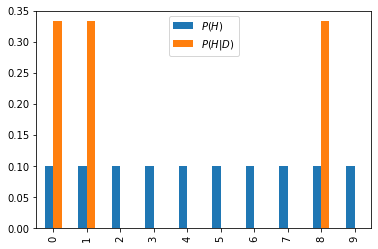

In [11]:
df = pd.DataFrame({
    'P_H': P_H,
    'P_H_given_D': P_H_given_D
})
fig, ax = plt.subplots()
df.plot(kind='bar', ax=ax)
ax.legend(['$P(H)$', '$P(H|D)$'])

#### Noisy sensors

sensor S를 통하여 D에 대한 정보를 얻을 때, 알고자 하는 사항 $P(H|S)$은 다음과 같다.

* $P(H|S) \propto P(H) \times P(S|H)$

그런데, $H=h \in \{0, 1, \cdots 9\}$에서 D는 고정되어 $P(D|H) = 1$이거나 $P(D^c|H) = 1$이 된다.

\begin{align}
P(S|H) &= P(S,D|H) + P(S,D^c|H) \\
&= P(D|H)P(S|D,H) \: \text{or} \: P(D^c|H)P(S|D^c,H) \\
&= 1 \times 3/4  \: \text{for} \: P(D|H) = 1 \: \text{else} \: 1/4
\end{align}

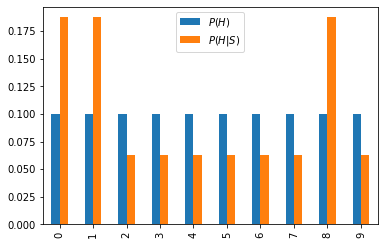

In [23]:
P_D_given_H = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
P_S_given_H = np.array([3/4 if d else 1/4 for d in P_D_given_H])
P_H_given_S = P_H * P_S_given_H
P_H_given_S = normalize(P_H_given_S)
df = pd.DataFrame({
    'P_H': P_H,
    'P_H_given_S': P_H_given_S
})
fig, ax = plt.subplots()
df.plot(kind='bar', ax=ax)
ax.legend(['$P(H)$', '$P(H|S)$'])

#### Incorporating movement